# 0. 프로젝트 기획

딥러닝
자연어처리(NLP)
감성 분석
다중 감성 분석

데이터 : AIhub 감성 대화 말뭉치

In [1]:
# 시각화 시 한글 폰트 설정

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [3]:
!pip install squarify

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
tf.random.set_seed(42)

from numpy.lib.function_base import average
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
# Mecab을 포함한 konlpy 설치

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt

# 1. 데이터 전처리

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_excel("/content/drive/MyDrive/코드스테이츠/Section4/Project/data/감성대화말뭉치(최종데이터)_Training.xlsx")

In [ ]:
val = pd.read_excel("/content/drive/MyDrive/코드스테이츠/Section4/Project/data/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [ ]:
train.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.
3,31303,노년,남성,재정,만성질환 무,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,재취업 후 첫 월급이라 정말 기쁘시겠어요.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...,이 기분을 유지하려면 어떻게 해야 할까요?,회사생활을 열심히 해서 계속 월급을 받을거야!,계속 원하시는 대로 회사생활이 이어지길 바랄게요.,NaN,NaN
4,47200,노년,여성,재정,만성질환 유,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,기분 좋으시겠어요. 앞으로는 어떻게 하실 생각이신가요?,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶으시군요.,NaN,NaN,NaN,NaN


In [ ]:
val.head()

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN
3,169,청년,남성,"진로, 취업, 직장",해당없음,당황,죄책감의,이번에 팀장님이 간단한 조사 업무를 부탁하셨는데 내가 잘못 처리했어. 너무 절망적이야.,팀장님이 부탁하신 업무를 잘못 처리하셔서 많이 당황하시고 놀라셨겠어요.,곧 있으면 인턴에서 정규직 전환 평가가 있는데 안 좋을 것 같아.,마음이 많이 안 좋으시겠어요. 지금 상황을 타개할 수 있는 가장 좋은 방안이 있을까요?,우선 잘못된 부분을 솔직하게 말씀드리고 수정하기 위해서 최선을 다해봐야겠어.,잘못된 부분을 잘 수정해서 좋은 결과가 있었으면 좋겠어요.,NaN,NaN
4,38435,중년,여성,"재정, 은퇴, 노후준비",해당없음,분노,노여워하는,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어.,많이 화가 나시겠어요.,어떻게 그럴 수가 있지? 너무 화가 나.,어떻게 하면 지금의 감정을 추스를 수 있을까요?,나도 변호사를 고용해서 한번 얘기해보려고 해.,자녀분들이랑 함께 하며 슬픔을 극복하시길 바라요.,NaN,NaN


In [ ]:
# input을 '사람문장1'(감정이 들어간 문장), output을 '감정_대분류'로 설정

train = train[['사람문장1', '감정_대분류']]
val = val[['사람문장1', '감정_대분류']]

In [ ]:
# NaN값 유무 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40879 entries, 0 to 40878
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   40879 non-null  object
 1   감정_대분류  40879 non-null  object
dtypes: object(2)
memory usage: 638.9+ KB


In [ ]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5130 entries, 0 to 5129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   사람문장1   5130 non-null   object
 1   감정_대분류  5130 non-null   object
dtypes: object(2)
memory usage: 80.3+ KB


In [ ]:
print(train['감정_대분류'].unique())
print(val['감정_대분류'].unique())
# train set에 '불안 ' 및 '기쁨 ' 과 같이 공백이 껴있는 데이터 발견

['기쁨' '불안' '당황' '슬픔' '분노' '상처' '불안 ' '기쁨 ']
['분노' '슬픔' '불안' '당황' '상처' '기쁨']


In [ ]:
train['감정_대분류'] = train['감정_대분류'].apply(lambda x : x.rstrip())

In [ ]:
train.columns = ['sentence', 'label']
val.columns = ['sentence', 'label']

In [ ]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

train['label'] = enc.fit_transform(train['label'])
val['label'] = enc.transform(val['label'])

# """
# 0 : 기쁨
# 1 : 당황
# 2 : 분노
# 3 : 불안
# 4 : 상처
# 5 : 슬픔
# """

# 2. 텍스트 전처리
- regex 전처리
- 형태소 분석기를 이용한 token화
- 불용어 사전을 이용한 불용어 제거

## 2-1. regex 전처리

In [ ]:
import re

train['sentence'] = train['sentence'].apply(lambda x : re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))
val['sentence'] = val['sentence'].apply(lambda x : re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x))

## 2-2. Tokenizer(형태소 분석기 이용)

In [ ]:
# Mecab을 포함한 konlpy 설치

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [ ]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt

han = Hannanum()
kkma = Kkma()
komo = Komoran()
mecab = Mecab()
okt = Okt()

In [ ]:
# 형태소 분석기 별 형태소 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab]:
    print(tokenizer.morphs(train['sentence'][0]))
print(okt.morphs(train['sentence'][0], stem=True)) # okt의 경우 stemming 기능 제공

In [ ]:
# 형태소 분석기 별 품사 태깅 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab, okt]:
    print(tokenizer.pos(train['sentence'][0]))

[('아내', 'N'), ('가', 'J'), ('드디어', 'M'), ('출산', 'N'), ('하', 'X'), ('게', 'E'), ('되', 'P'), ('어서', 'E'), ('정말', 'M'), ('신', 'N'), ('이', 'J'), ('나', 'N')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'ECD'), ('되', 'VV'), ('어서', 'ECD'), ('정말', 'MAG'), ('신이', 'NNG'), ('나', 'NNG')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('되', 'VV'), ('어서', 'EC'), ('정말', 'MAG'), ('신이', 'NNP'), ('나', 'NP')]
[('아내', 'NNG'), ('가', 'JKS'), ('드디어', 'MAG'), ('출산', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('되', 'VV'), ('어서', 'EC'), ('정말', 'MAG'), ('신', 'NNG'), ('이', 'JKS'), ('나', 'VV+EC')]
[('아내', 'Noun'), ('가', 'Josa'), ('드디어', 'Adverb'), ('출산', 'Noun'), ('하게', 'Verb'), ('되어서', 'Verb'), ('정말', 'Noun'), ('신', 'Noun'), ('이', 'Josa'), ('나', 'Noun')]


In [ ]:
# 형태소 분석기 별 명사 태깅 단위 토큰화 테스트

for tokenizer in [han, kkma, komo, mecab, okt]:
    print(tokenizer.nouns(train['sentence'][0]))

['아내', '출산', '신', '나']
['아내', '출산', '신이', '나']
['아내', '출산', '신이']
['아내', '출산', '신']
['아내', '출산', '정말', '신', '나']


In [ ]:
# Mecab 을 이요하여 형태소 단위로 토큰화 결정

train['tokens'] = train['sentence'].apply(lambda x : mecab.morphs(x))
val['tokens'] = val['sentence'].apply(lambda x : mecab.morphs(x))

In [ ]:
train.head()

,sentence,label,tokens
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 가, 드디어, 출산, 하, 게, 되, 어서, 정말, 신, 이, 나]"
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 때문, 에, 먹, 어야, 할, 약, 이, 열, 가지, 가, ..."
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 에, 올라오, 니, 중학교, 때, 보다, 수업, 이, 갑자기, 어려워져..."
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 이, 돼서, 받, 게, 된, 첫, 월급, 으로, 온, 가족, 이, 외식,..."
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 을, 드디어, 다, 갚, 게, 되, 어서, 이제야, 안도감, 이, 들, 어]"


## 2-3. 불용어 제거

In [ ]:
stop_words_1 = pd.read_table('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/한국어불용어100.txt', header=None) # https://bab2min.tistory.com/544#google_vignette

In [ ]:
stop_words_2 = pd.read_csv('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/한국어불용어(rank_nl_stopwords_korean).txt', header=None) # https://www.ranks.nl/stopwords/korean

In [ ]:
# 실제 단어만 추출

stop_words_1 = stop_words_1[[0]]

In [ ]:
stop_words_1.head()

,0
0,이
1,있
2,하
3,것
4,들


In [ ]:
stop_words_2.head()

,0
0,아
1,휴
2,아이구
3,아이쿠
4,아이고


In [ ]:
stop_words = pd.concat([stop_words_1, stop_words_2])
stop_words.drop_duplicates(subset=[0], inplace=True)
stop_words.reset_index(drop=True, inplace=True)
stop_words = np.array(stop_words[0])

In [ ]:
train.columns

Index(['sentence', 'label', 'tokens'], dtype='object')

In [ ]:
# 형태소 단위 토큰화에서 불용어 제거

temp = []

for tokens in train['tokens']:
    temp.append([token for token in tokens if token not in stop_words])

train['tokens'] = temp

In [ ]:
temp = []

for tokens in val['tokens']:
    temp.append([token for token in tokens if token not in stop_words])

val['tokens'] = temp

In [ ]:
# tokinze까지 완료, 중간 저장
# df.to_csv()로 저장하는 경우, dataframe내의 list 개체가 문자열처리가 되어버림
# pickle을 통하면 자료 type을 유지한채로 저장 가능
train.to_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/train_token.pkl')
val.to_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/val_token.pkl')

In [ ]:
# 여기서부터 다시 시작할 때

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd

train = pd.read_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/train_token.pkl')
val = pd.read_pickle('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/val_token.pkl')

# 3. EDA 및 시각화

In [5]:
# """
# 0 : 기쁨
# 1 : 당황
# 2 : 분노
# 3 : 불안
# 4 : 상처
# 5 : 슬픔
# """

In [ ]:
train['tokens_ct'] = train['tokens'].apply(lambda x : len(x))

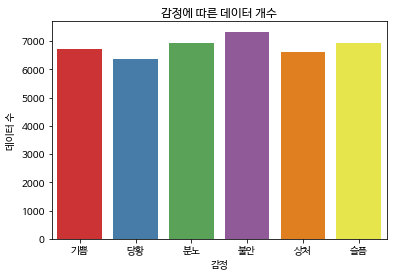

In [ ]:
# 라벨값에 따른 데이터 불균형 확인

sns.barplot(data=train, x=['기쁨', '당황', '분노', '불안', '상처', '슬픔'], y=train.groupby(by='label').count()['tokens_ct'], palette='Set1')
plt.title('감정에 따른 데이터 개수')
plt.xlabel('감정')
plt.ylabel('데이터 수')
plt.show();

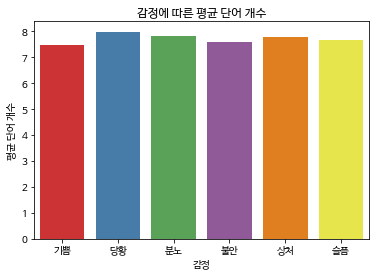

In [ ]:
sns.barplot(data=train, x=['기쁨', '당황', '분노', '불안', '상처', '슬픔'], y=train.groupby(by='label').mean()['tokens_ct'], palette='Set1')
plt.title('감정에 따른 평균 단어 개수')
plt.xlabel('감정')
plt.ylabel('평균 단어 개수')
plt.show();

In [ ]:
from collections import Counter

# Counter 객체는 리스트요소의 값과 요소의 갯수를 카운트 하여 저장하고 있습니다.
# 카운터 객체는 .update 메소드로 계속 업데이트 가능합니다.

def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 문서에 단어가 존재하느냐 안하느냐, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
# 개수 상위 20개 단어

wc = word_count(train['tokens'])
wc.head(20)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
35,너무,7813,7989,1.0,0.025319,0.025319,0.191125
67,친구,6740,7442,2.0,0.023586,0.048905,0.164877
53,었,3357,3495,3.0,0.011077,0.059981,0.082120
97,해서,3055,3111,4.0,0.009860,0.069841,0.074733
46,만,2718,2851,5.0,0.009036,0.078877,0.066489
0,어서,2512,2568,6.0,0.008139,0.087015,0.061450
241,회사,2192,2276,7.0,0.007213,0.094228,0.053622
107,아서,2237,2259,8.0,0.007159,0.101388,0.054722
86,오늘,2239,2246,9.0,0.007118,0.108506,0.054771
153,요즘,2203,2208,10.0,0.006998,0.115504,0.053891


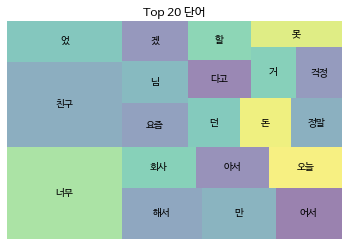

In [ ]:
# 개수 상위 20개 단어 시각화

wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['percent'], label=wc_top20['word'], alpha=0.55)
plt.title('Top 20 단어')
plt.axis('off')
plt.show();

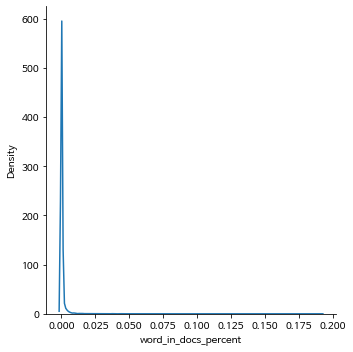

In [ ]:
# 전체 문서에서 차지하는 퍼센트에 따른 밀도

sns.displot(wc['word_in_docs_percent'],kind='kde')
plt.show();

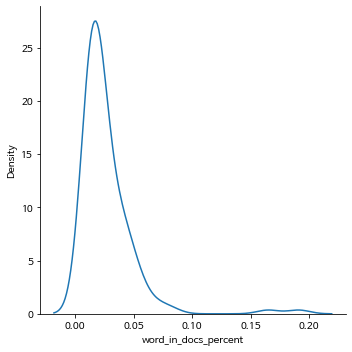

In [ ]:
# 전체 문서에서 차지하는 0.01퍼센트 이상 밀도

sns.displot(wc[wc['word_in_docs_percent']>=0.01]['word_in_docs_percent'],kind='kde')
plt.show();

# 4. 벡터화(정수 인코딩)

In [ ]:
train.head()

,sentence,label,tokens,tokens_ct
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 드디어, 출산, 어서, 정말, 신]",6
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]",10
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]",10
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]",12
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 드디어, 갚, 어서, 이제야, 안도감]",6


In [6]:
# 훈련, 검증 셋 분리

X_train = train['tokens']
y_train = train['label']
X_val = val['tokens']
y_val = val['label']

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 훈련셋에 대해서 tokenizer fit

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [8]:
print(tokenizer.word_index)

{'너무': 1, '친구': 2, '었': 3, '해서': 4, '만': 5, '어서': 6, '회사': 7, '아서': 8, '오늘': 9, '요즘': 10, '님': 11, '겠': 12, '던': 13, '돈': 14, '정말': 15, '다고': 16, '할': 17, '거': 18, '걱정': 19, '못': 20, '스러워': 21, '아내': 22, '건강': 23, '한테': 24, '남편': 25, '니': 26, '화': 27, '힘들': 28, '결혼': 29, '서': 30, '라고': 31, '많이': 32, '직장': 33, '기분': 34, '돼': 35, '마음': 36, '학교': 37, '아들': 38, '엄마': 39, '당황': 40, '준비': 41, '해야': 42, '슬퍼': 43, '먹': 44, '불안': 45, '랑': 46, '나이': 47, '남자': 48, '짜증': 49, '자식': 50, '부모': 51, '이제': 52, '가족': 53, '자꾸': 54, '취업': 55, '인데': 56, '난': 57, '날': 58, '걸': 59, '대': 60, '다는': 61, '딸': 62, '인': 63, '애': 64, '노후': 65, '싫': 66, '보다': 67, '병원': 68, '은퇴': 69, '공부': 70, '갑자기': 71, '어제': 72, '다니': 73, '몸': 74, '기뻐': 75, '면서': 76, '됐': 77, '아빠': 78, '줄': 79, '죽': 80, '아직': 81, '스트레스': 82, '더니': 83, '속상해': 84, '상사': 85, '업무': 86, '달': 87, '왔': 88, '연락': 89, '라': 90, '아무': 91, '성적': 92, '시험': 93, '갔': 94, '계속': 95, '남': 96, '다가': 97, '병': 98, '할지': 99, '선생': 100, '된': 101, '는지': 102, '려고': 103, '만나

In [9]:
tokenizer.word_counts

OrderedDict([('아내', 1728),
             ('드디어', 315),
             ('출산', 223),
             ('어서', 2568),
             ('정말', 1887),
             ('신', 196),
             ('당뇨', 181),
             ('랑', 1014),
             ('합병증', 46),
             ('먹', 1026),
             ('어야', 198),
             ('할', 1829),
             ('약', 214),
             ('열', 139),
             ('넘어가', 24),
             ('스트레스', 632),
             ('고등학교', 107),
             ('올라오', 11),
             ('니', 1551),
             ('중학교', 31),
             ('보다', 769),
             ('수업', 101),
             ('갑자기', 688),
             ('어려워져서', 20),
             ('당황', 1069),
             ('스러워', 1746),
             ('재취업', 24),
             ('돼서', 380),
             ('된', 540),
             ('첫', 94),
             ('월급', 116),
             ('온', 175),
             ('가족', 951),
             ('외식', 42),
             ('예정', 34),
             ('너무', 7989),
             ('행복', 259),
             ('빚', 108),
       

In [10]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 전체 훈련데이터 단어 수(단어 종류의 개수)
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 수 총합(단어 종류 별 각각의 개수 총합)
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수 총합

# 각 단어와 단어 별 등장 개수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq += value

    # 단어의 등장 빈도수가 threshold보다 작은 경우(즉, 여기서는 등장 횟수가 1개인 단어의 갯수)
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value

print('총 단어 개수 :',total_cnt)
print(f'등장 빈도가 {threshold - 1}번 이하인 희귀 단어의 수: {rare_cnt}') # 1번 이하
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

총 단어 개수 : 12149
등장 빈도가 1번 이하인 희귀 단어의 수: 4201
단어 집합에서 희귀 단어의 비율: 34.578977693637334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3314064228237479


In [11]:
# 전체 단어 개수 중 빈도수 1개 인 단어는 제거
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7949


In [12]:
# 빈도수 1개인 단어 제거, 즉 빈도수 2개 이상인 단어들만 학습

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

In [13]:
print(X_train[:3])

[[22, 170, 246, 6, 15, 284], [313, 46, 989, 44, 280, 17, 258, 412, 1558, 82], [528, 2549, 26, 1318, 67, 560, 71, 1745, 40, 21]]


In [14]:
y_train = np.array(train['label'])
y_val = np.array(val['label'])

In [15]:
# 빈도수 1 이하인 단어 제거 후, 문장 자체가 사라진 경우

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [16]:
# 사라진 sentence 제거

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

40865
40865


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


토큰화된 문장의 최대 길이 : 39
토큰화된 문장의 평균 길이 : 7.6184999388229535


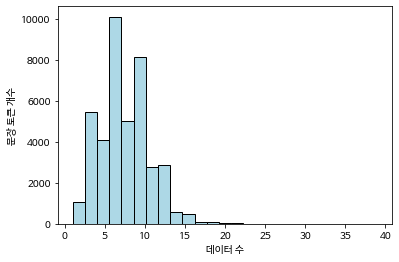

In [17]:
import matplotlib.pyplot as plt

print('토큰화된 문장의 최대 길이 :',max(len(tokens) for tokens in X_train))
print('토큰화된 문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(tokens) for tokens in X_train], bins=25, color='lightblue', edgecolor='k')
plt.xlabel('데이터 수')
plt.ylabel('문장 토큰 개수')
plt.show();

In [18]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {(count / len(nested_list))*100}')

In [19]:
max_len = 13
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 13 이하인 샘플의 비율: 96.73803988743424


In [20]:
# 13개에 맞춰 padding, 이 때 문장에서 사람의 감정은 후반에 있을 것으로 기대하여 padding='pre'로 진행

X_train = pad_sequences(X_train, maxlen=max_len, padding='pre')
X_val = pad_sequences(X_val, maxlen=max_len, padding='pre')

# 5. 모델링 및 훈련

In [41]:
# 모델 학습 시 알람

from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://freesound.org/data/previews/219/219244_4082826-lq.mp3', autoplay=True))
# Insert whatever audio file you want above

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 5-1. GAP1D

In [65]:
# vocab_size=7949
embedding_dim = 256
hidden_units = 128

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim))
model1.add(GlobalAveragePooling1D()) 
model1.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model1.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

Epoch 1/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.3809 - acc: 0.5221
Epoch 1: val_acc improved from -inf to 0.57758, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model1.h5
1278/1278 [==============================] - 4s 3ms/step - loss: 1.3809 - acc: 0.5221 - val_loss: 1.1701 - val_acc: 0.5776
Epoch 2/15
1276/1278 [============================>.] - ETA: 0s - loss: 1.0857 - acc: 0.6100
Epoch 2: val_acc improved from 0.57758 to 0.58363, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model1.h5
1278/1278 [==============================] - 4s 3ms/step - loss: 1.0856 - acc: 0.6100 - val_loss: 1.1366 - val_acc: 0.5836
Epoch 3/15
1264/1278 [============================>.] - ETA: 0s - loss: 1.0391 - acc: 0.6317
Epoch 3: val_acc improved from 0.58363 to 0.59474, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model1.h5
1278/1278 [==============================] - 3s 3ms/step -

In [66]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model1.h5')
print(f"\n 테스트 정확도: {loaded_model.evaluate(X_val, y_val)[1]:.4f}")

161/161 [==============================] - 0s 2ms/step - loss: 1.1254 - acc: 0.5981

 테스트 정확도: 0.5981


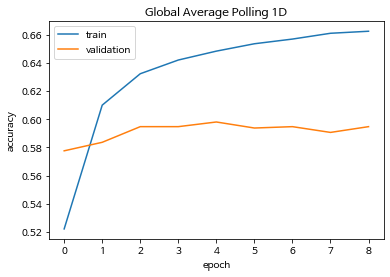

In [67]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('Global Average Polling 1D')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show();

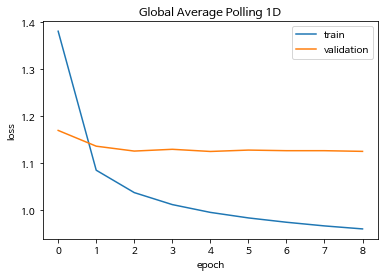

In [68]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Global Average Polling 1D')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

## 5-2. LSTM

In [69]:
# vocab_size=7949
embedding_dim = 256
hidden_units = 128

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2)) 
model2.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

Epoch 1/15
1278/1278 [==============================] - ETA: 0s - loss: 1.2023 - acc: 0.5571
Epoch 1: val_acc improved from -inf to 0.59357, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5
1278/1278 [==============================] - 68s 51ms/step - loss: 1.2023 - acc: 0.5571 - val_loss: 1.1181 - val_acc: 0.5936
Epoch 2/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0357 - acc: 0.6260
Epoch 2: val_acc did not improve from 0.59357
1278/1278 [==============================] - 62s 49ms/step - loss: 1.0357 - acc: 0.6260 - val_loss: 1.1136 - val_acc: 0.5910
Epoch 3/15
1278/1278 [==============================] - ETA: 0s - loss: 0.9728 - acc: 0.6516
Epoch 3: val_acc improved from 0.59357 to 0.61072, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5
1278/1278 [==============================] - 60s 47ms/step - loss: 0.9728 - acc: 0.6516 - val_loss: 1.0914 - val_acc: 0.6107
Epoch 4/15
1278/1278 [=

In [70]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5')
print(f"\n 테스트 정확도: {loaded_model.evaluate(X_val, y_val)[1]:.4f}")

161/161 [==============================] - 1s 5ms/step - loss: 1.0914 - acc: 0.6107

 테스트 정확도: 0.6107


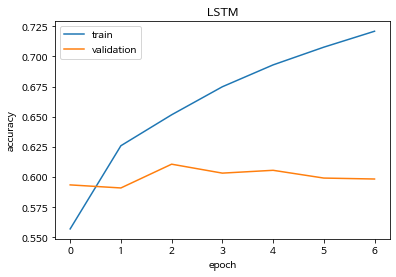

In [71]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('LSTM')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show();

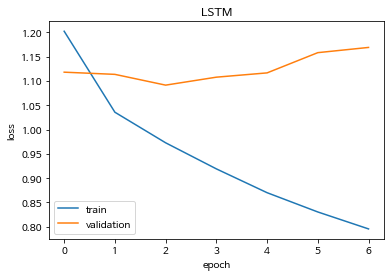

In [72]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

## 5-3. GRU

In [73]:
# vocab_size=7949
embedding_dim = 256
hidden_units = 128

model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim))
model3.add(GRU(hidden_units, dropout=0.2, recurrent_dropout=0.2)) 
model3.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model3.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

Epoch 1/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.1941 - acc: 0.5612
Epoch 1: val_acc improved from -inf to 0.58986, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5
1278/1278 [==============================] - 57s 43ms/step - loss: 1.1942 - acc: 0.5611 - val_loss: 1.1212 - val_acc: 0.5899
Epoch 2/15
1278/1278 [==============================] - ETA: 0s - loss: 1.0441 - acc: 0.6239
Epoch 2: val_acc did not improve from 0.58986
1278/1278 [==============================] - 54s 42ms/step - loss: 1.0441 - acc: 0.6239 - val_loss: 1.1152 - val_acc: 0.5887
Epoch 3/15
1278/1278 [==============================] - ETA: 0s - loss: 0.9778 - acc: 0.6503
Epoch 3: val_acc improved from 0.58986 to 0.60975, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5
1278/1278 [==============================] - 55s 43ms/step - loss: 0.9778 - acc: 0.6503 - val_loss: 1.0897 - val_acc: 0.6097
Epoch 4/15
1277/1278 [=

In [74]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model3.h5')
print(f"\n 테스트 정확도: {loaded_model.evaluate(X_val, y_val)[1]:.4f}")

161/161 [==============================] - 1s 5ms/step - loss: 1.0897 - acc: 0.6097

 테스트 정확도: 0.6097


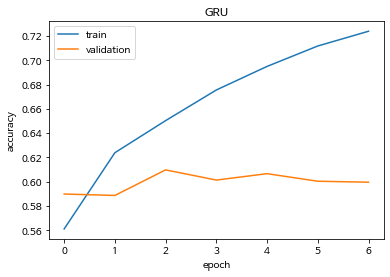

In [75]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('GRU')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show();

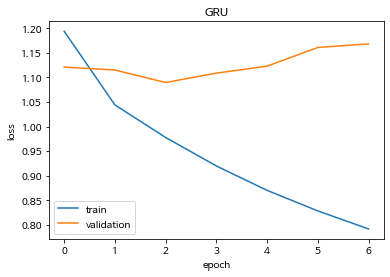

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('GRU')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

## 5-4. LSTM with Dense relu

In [89]:
# vocab_size=7949
embedding_dim = 256
hidden_units = 128

model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim))
model4.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2)) 
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model4.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model4.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

allDone()

Epoch 1/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.2584 - acc: 0.5426
Epoch 1: val_acc improved from -inf to 0.58538, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model4.h5
1278/1278 [==============================] - 63s 48ms/step - loss: 1.2584 - acc: 0.5425 - val_loss: 1.1380 - val_acc: 0.5854
Epoch 2/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0918 - acc: 0.6151
Epoch 2: val_acc improved from 0.58538 to 0.59298, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model4.h5
1278/1278 [==============================] - 61s 48ms/step - loss: 1.0918 - acc: 0.6150 - val_loss: 1.1160 - val_acc: 0.5930
Epoch 3/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0366 - acc: 0.6392
Epoch 3: val_acc improved from 0.59298 to 0.60546, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model4.h5
1278/1278 [==============================] - 61s 47ms/

In [90]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model4.h5')
print(f"\n 테스트 정확도: {loaded_model.evaluate(X_val, y_val)[1]:.4f}")

161/161 [==============================] - 1s 5ms/step - loss: 1.1195 - acc: 0.6055

 테스트 정확도: 0.6055


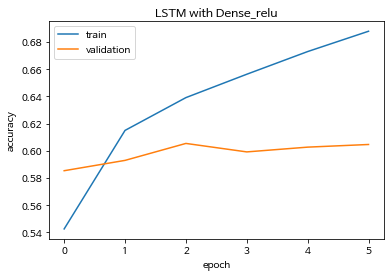

In [91]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('LSTM with Dense_relu')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show();

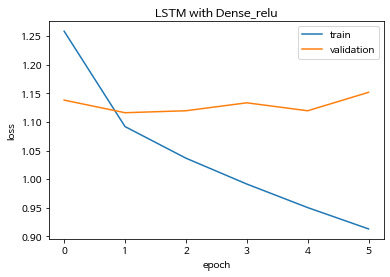

In [92]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('LSTM with Dense_relu')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

## 5-5. GRU with Dense relu

In [85]:
# vocab_size=7949
embedding_dim = 256
hidden_units = 128

model5 = Sequential()
model5.add(Embedding(vocab_size, embedding_dim))
model5.add(GRU(hidden_units, dropout=0.2, recurrent_dropout=0.2)) 
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(6, activation='softmax')) # 클래스 6개이므로 softmax에 따른 다중 분류

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model5.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model5.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_data=[X_val, y_val])

allDone()

Epoch 1/15
1278/1278 [==============================] - ETA: 0s - loss: 1.2566 - acc: 0.5423
Epoch 1: val_acc improved from -inf to 0.58908, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model5.h5
1278/1278 [==============================] - 58s 43ms/step - loss: 1.2566 - acc: 0.5423 - val_loss: 1.1320 - val_acc: 0.5891
Epoch 2/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.1030 - acc: 0.6106
Epoch 2: val_acc did not improve from 0.58908
1278/1278 [==============================] - 55s 43ms/step - loss: 1.1030 - acc: 0.6105 - val_loss: 1.1272 - val_acc: 0.5830
Epoch 3/15
1277/1278 [============================>.] - ETA: 0s - loss: 1.0431 - acc: 0.6345
Epoch 3: val_acc improved from 0.58908 to 0.60799, saving model to /content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model5.h5
1278/1278 [==============================] - 55s 43ms/step - loss: 1.0431 - acc: 0.6346 - val_loss: 1.1021 - val_acc: 0.6080
Epoch 4/15
1277/1278 [=

In [86]:
loaded_model = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model5.h5')
print(f"\n 테스트 정확도: {loaded_model.evaluate(X_val, y_val)[1]:.4f}")

161/161 [==============================] - 1s 5ms/step - loss: 1.1177 - acc: 0.6084

 테스트 정확도: 0.6084


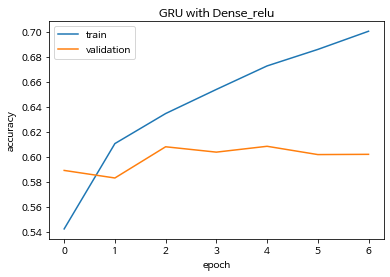

In [87]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('GRU with Dense_relu')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show();

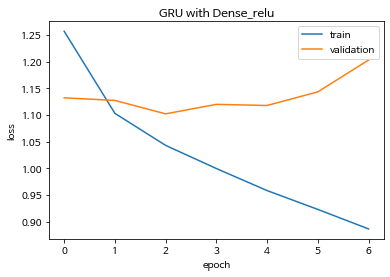

In [88]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('GRU with Dense_relu')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

# 6. 모델 평가 및 기타 시각화

In [98]:
model_final = load_model('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/best_model2.h5')

In [103]:
class_names = [0, 1, 2, 3, 4, 5]

predictions = model_final.predict(X_val)
predictions = np.argmax(predictions, axis=1)
y_pred_val = [class_names[pred] for pred in predictions]

In [120]:
from numpy.lib.function_base import average
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print(f'accuracy score : {accuracy_score(y_val, y_pred_val):.4f}')
print(f'precision score : {precision_score(y_val, y_pred_val, average="micro"):.4f}')
print(f'recall score : {recall_score(y_val, y_pred_val, average="micro"):.4f}')
print(f'f1 score : {f1_score(y_val, y_pred_val, average="micro"):.4f}')

accuracy score : 0.6107
precision score : 0.6107
recall score : 0.6107
f1 score : 0.6107


In [122]:
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

# """
# 0 : 기쁨
# 1 : 당황
# 2 : 분노
# 3 : 불안
# 4 : 상처
# 5 : 슬픔
# """

[[697  22  39  45  15  23]
 [ 67 433 102  80  80  70]
 [ 48  52 529  97  76  71]
 [ 59  86  71 581  44  66]
 [ 58  96  87  75 402  98]
 [ 61  61  89  71  88 491]]
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       841
           1       0.58      0.52      0.55       832
           2       0.58      0.61      0.59       873
           3       0.61      0.64      0.63       907
           4       0.57      0.49      0.53       816
           5       0.60      0.57      0.58       861

    accuracy                           0.61      5130
   macro avg       0.61      0.61      0.61      5130
weighted avg       0.61      0.61      0.61      5130



In [152]:
i = 0
acc = []

for count in confusion_matrix(y_val, y_pred_val):
    acc.append(round(count[i]/sum(count), 2))
    i += 1

print(acc)

[0.83, 0.52, 0.61, 0.64, 0.49, 0.57]


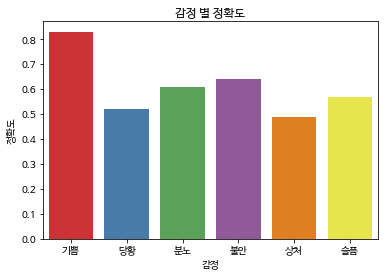

In [153]:
sns.barplot(data=train, x=['기쁨', '당황', '분노', '불안', '상처', '슬픔'], y=acc, palette='Set1')
plt.title('감정 별 정확도')
plt.xlabel('감정')
plt.ylabel('정확도')
plt.show();

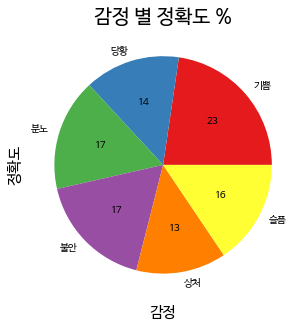

In [184]:
colors = sns.color_palette('Set1')[0:6]
plt.figure(figsize=(5,5))
plt.pie(acc,labels=['기쁨', '당황', '분노', '불안', '상처', '슬픔'], autopct='%.0f', colors=colors)
plt.title('감정 별 정확도 %', size=20)
plt.xlabel('감정', size=15)
plt.ylabel('정확도', size=15)
plt.show();

In [136]:
from wordcloud import WordCloud

In [140]:
train.groupby(by='label').sum()

,sentence,tokens
label,,
0,아내가 드디어 출산하게 되어서 정말 신이 나재취업이 돼서 받게 된 첫 월급으로 온 ...,"[아내, 드디어, 출산, 어서, 정말, 신, 재취업, 돼서, 된, 첫, 월급, 온,..."
1,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워오늘 선생님이 ...,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러..."
2,이제 돈이라면 지긋지긋해친구들이 나를 괴롭혀 부모님과 선생님께 얘기했는데도 믿어주지...,"[이제, 돈, 라면, 지긋지긋, 친구, 괴롭혀, 부모, 님, 선생, 님, 얘기, 믿..."
3,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야이제 곧 은퇴할...,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스, 이제, 은퇴..."
4,새로 간 치과에서 조금 썩기만 한 이를 임플란트를 하라고 했어 과잉진료는 안 한다더...,"[새로, 간, 치과, 썩, 만, 임, 플란트, 라고, 과잉, 진료, 한다더니, 부인..."
5,사십 대에 접어들면서 머리카락이 많이 빠져 고민이야친구 때문에 눈물 나남편과 건강하...,"[십, 대, 접어들, 면서, 머리카락, 많이, 빠져, 고민, 친구, 눈물, 남편, ..."


In [207]:
from PIL import Image

mask = Image.open('/content/drive/MyDrive/코드스테이츠/Section4/Project/data/output.png')
mask = np.array(mask)


WC = WordCloud(
    font_path='/content/drive/MyDrive/코드스테이츠/Section4/Project/data/malgunbd.ttf',
    background_color='white',
    width=800,
    height=600,
    max_words=100,
    mask=mask)

WC.generate(train['sentence'].sum())

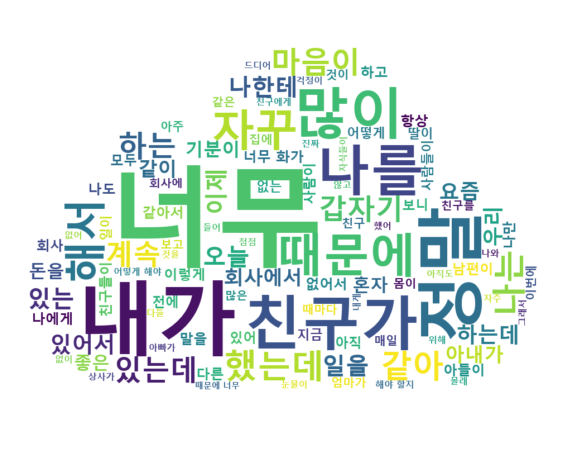

In [208]:
plt.figure(figsize=(10,10))

plt.imshow(WC, interpolation="bilinear")
plt.axis("off")
plt.show();

In [211]:
val['label_pred'] = y_pred_val

In [213]:
val[val['label']== val['label_pred']]

,sentence,label,tokens,label_pred
1,엄마가 결국 집을 나갔어 너무 너무 슬퍼,5,"[엄마, 나갔, 너무, 너무, 슬퍼]",5
4,남편이 이혼할 때 위자료를 주지 않으려고 변호사를 고용했어,2,"[남편, 이혼, 할, 위자료, 으려고, 변호사, 고용]",2
6,직장에서 모함을 받았어 난 정말 억울해,4,"[직장, 모함, 난, 정말, 억울]",4
7,요즘 딸에게 뭔가 물어보면 신경질부터 내는데 화가 나,2,"[요즘, 딸, 뭔가, 물, 신경질, 화]",2
8,언제까지 대출금을 갚으며 살아야 할까 포기하고 싶어지고 너무 슬퍼,5,"[대출금, 갚, 으며, 할까, 포기, 너무, 슬퍼]",5
...,...,...,...,...
5121,투자했던 기업의 주가가 떨어졌어,5,"[투자, 던, 기업, 주가, 떨어졌]",5
5122,엄마가 잔소리하시는데 너무 귀찮고 성가셔,2,"[엄마, 잔소리, 시, 너무, 귀찮, 성가셔]",2
5123,요즘 자식들과 아내가 내게 요구하는 게 점점 많아지는 거 같아서 짜증 나,2,"[요즘, 자식, 아내, 내게, 요구, 점점, 거, 아서, 짜증]",2
5125,부동산 임대 소득으로 현재 여유롭게 살 수 있어서 좋단다,0,"[부동산, 임대, 소득, 현재, 여유, 롭, 어서, 단다]",0


In [214]:
train.head()

,sentence,label,tokens
0,아내가 드디어 출산하게 되어서 정말 신이 나,0,"[아내, 드디어, 출산, 어서, 정말, 신]"
1,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,3,"[당뇨, 랑, 합병증, 먹, 어야, 할, 약, 열, 넘어가, 스트레스]"
2,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,1,"[고등학교, 올라오, 니, 중학교, 보다, 수업, 갑자기, 어려워져서, 당황, 스러워]"
3,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,0,"[재취업, 돼서, 된, 첫, 월급, 온, 가족, 외식, 할, 예정, 너무, 행복]"
4,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,0,"[빚, 드디어, 갚, 어서, 이제야, 안도감]"
